In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchsummary import summary
from torchvision.ops import sigmoid_focal_loss

import time
import copy
import os

In [2]:
data_dir = '../../../../IIT/IIT Sem 7/IE 643/Challenge_Dataset/Images'
mask_dir = '../../../../IIT/IIT Sem 7/IE 643/Challenge_Dataset/Masks'

In [3]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.RandomAdjustSharpness(2, 1),
        transforms.ColorJitter(),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((128,128)),
        # transforms.RandomAdjustSharpness(2, 1),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
}
mask_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])
}

In [4]:
class ImageMaskDataset(Dataset):
    def __init__(self, data_dir, mask_dir, train = True, transform = None, mask_transform = None) -> None:
        super(ImageMaskDataset, self).__init__()
        self.imgs = []
        self.transform = transform
        if train:
            for file1 in os.scandir(data_dir+'/Train'):
                file2 = mask_dir+'/Train/'+file1.name[:-3]+'png'
                if self.transform is not None:
                    self.imgs.append((self.transform(Image.open(file1.path).convert('RGB')),mask_transform(Image.open(file2))))
                else:
                    self.imgs.append((Image.open(file1.path).convert('RGB'),Image.open(file2)))
        else:
            for file1 in os.scandir(data_dir+'/Validation'):
                file2 = mask_dir+'/Validation/'+file1.name[:-3]+'png'
                if self.transform is not None:
                    self.imgs.append((self.transform(Image.open(file1.path).convert('RGB')),mask_transform(Image.open(file2))))
                else:
                    self.imgs.append((Image.open(file1.path).convert('RGB'),Image.open(file2)))
                    # if self.imgs[-1][0].shape[0] == 1:
                    #     self.imgs[-1] = (self.imgs[-1][0].repeat(3,1,1), self.imgs[-1][1])
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        return self.imgs[index]

In [5]:
train_data = ImageMaskDataset(data_dir, mask_dir, train = True, transform=data_transforms['Train'], mask_transform=mask_transforms['Train'])
val_data = ImageMaskDataset(data_dir, mask_dir, train = False, transform=data_transforms['Validation'], mask_transform=mask_transforms['Validation'])

In [6]:
train_loader = DataLoader(
    train_data,
    batch_size = 32,
    shuffle = True,
)
val_loader = DataLoader(
    val_data,
    batch_size = 32,
    shuffle = True,
)

In [7]:
def image_show(image, mask, pred = None):
    image = image*0.5 + 0.5
    mask = mask*0.5 + 0.5
    plt.figure(figsize=(20,10))
    if pred is not None:
        plt.subplot(1,3,1)
        plt.title('Image')
        plt.imshow(image.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,2)
        plt.title('True Mask')
        plt.imshow(mask.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,3)
        plt.title('Predicted Mask')
        plt.imshow(pred.detach().numpy().transpose((1,2,0)), cmap='gray')
    else:
        plt.subplot(1,3,1)
        plt.title('Image')
        plt.imshow(image.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,2)
        plt.title('Mask')
        plt.imshow(mask.numpy().transpose((1,2,0)), cmap='gray')

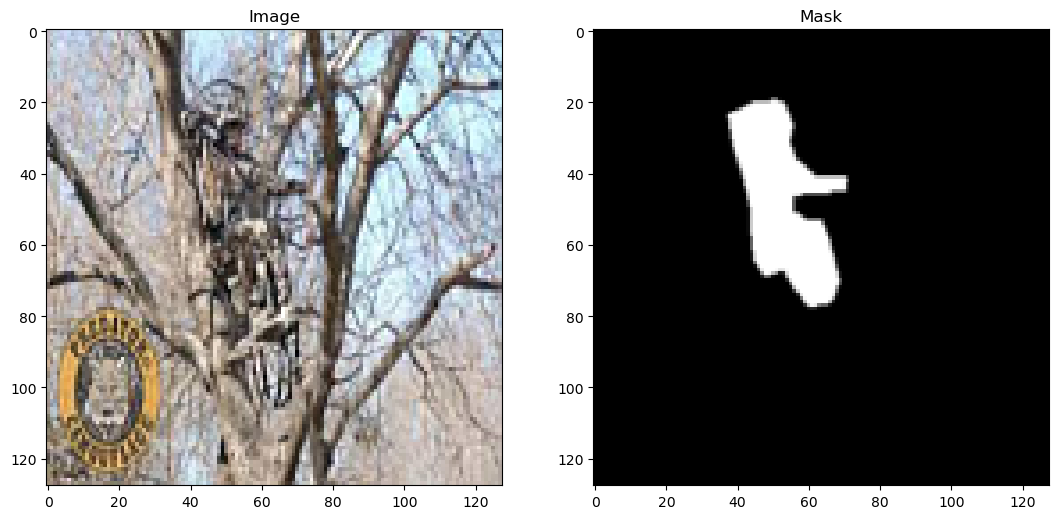

In [8]:
dataiter = iter(train_loader)
image, mask = next(dataiter)
index = 0
image_show(image[index], mask[index])

In [9]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [10]:
class DenseBlock(nn.Sequential):
    def __init__(self, channels: int, output_channels: int) -> None:
        super(DenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels+0*output_channels, output_channels, 9, 1, 'same')
        self.norm1 = nn.BatchNorm2d(output_channels)
        self.conv2 = nn.Conv2d(channels+1*output_channels, output_channels, 9, 1, 'same')
        self.norm2 = nn.BatchNorm2d(output_channels)
        self.conv3 = nn.Conv2d(channels+2*output_channels, output_channels, 7, 1, 'same')
        self.norm3 = nn.BatchNorm2d(output_channels)
        self.conv4 = nn.Conv2d(channels+3*output_channels, output_channels, 7, 1, 'same')
        self.norm4 = nn.BatchNorm2d(output_channels)
        self.conv5 = nn.Conv2d(channels+4*output_channels, output_channels, 5, 1, 'same')
        self.norm5 = nn.BatchNorm2d(output_channels)
        self.conv6 = nn.Conv2d(channels+5*output_channels, output_channels, 5, 1, 'same')
        self.norm6 = nn.BatchNorm2d(output_channels)
        self.conv7 = nn.Conv2d(channels+6*output_channels, output_channels, 3, 1, 'same')
        self.norm7 = nn.BatchNorm2d(output_channels)
        self.conv8 = nn.Conv2d(channels+7*output_channels, output_channels, 3, 1, 'same')
        self.norm8 = nn.BatchNorm2d(output_channels)
        self.conv9 = nn.Conv2d(channels+8*output_channels, output_channels, 3, 1, 'same')
        self.norm9 = nn.BatchNorm2d(output_channels)
        self.conv10 = nn.Conv2d(channels+9*output_channels, output_channels, 3, 1, 'same')
        self.norm10 = nn.BatchNorm2d(output_channels)
        self.convFinal = nn.Conv2d(channels+10*output_channels, channels, 1)
        self.normFinal = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        temp = x
        x_temp = torch.relu(self.norm1(self.conv1(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm2(self.conv2(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm3(self.conv3(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm4(self.conv4(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm5(self.conv5(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm6(self.conv6(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm7(self.conv7(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm8(self.conv8(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm9(self.conv9(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm10(self.conv10(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x = torch.relu(self.normFinal(self.convFinal(temp)))
        return x

In [11]:
den = DenseBlock(512,64)
summary(den, (512,16,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]       2,654,272
       BatchNorm2d-2           [-1, 64, 16, 16]             128
            Conv2d-3           [-1, 64, 16, 16]       2,986,048
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5           [-1, 64, 16, 16]       2,007,104
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7           [-1, 64, 16, 16]       2,207,808
       BatchNorm2d-8           [-1, 64, 16, 16]             128
            Conv2d-9           [-1, 64, 16, 16]       1,228,864
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]       1,331,264
      BatchNorm2d-12           [-1, 64, 16, 16]             128
           Conv2d-13           [-1, 64, 16, 16]         516,160
      BatchNorm2d-14           [-1, 64,

In [25]:
class UNet(nn.Module):
    def __init__(self) -> None:
        super(UNet, self).__init__()

        # ENCODER
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 'same') # 128, 128, 3 --> 128, 128, 64
        self.norm1 = nn.BatchNorm2d(64)
        self.denseBlock1 = DenseBlock(64, 8).to(device)

        self.maxpool1 = nn.MaxPool2d(2,2) # 64, 64, 64

        self.conv2 = nn.Conv2d(64, 128, 3, 1, 'same') # 64, 64, 64 --> 64, 64, 128
        self.norm2 = nn.BatchNorm2d(128)
        self.denseBlock2 = DenseBlock(128, 16).to(device) # 64, 64, 128

        self.maxpool2 = nn.MaxPool2d(2,2) # 32, 32, 128

        self.conv3 = nn.Conv2d(128, 256, 3, 1, 'same') # 32, 32, 128 --> 32, 32, 256
        self.norm3 = nn.BatchNorm2d(256)
        self.denseBlock3 = DenseBlock(256, 32).to(device) # 32, 32, 256

        self.maxpool3 = nn.MaxPool2d(2,2) # 16, 16, 256

        self.conv4 = nn.Conv2d(256, 512, 3, 1, 1) # 16, 16, 256 --> 16, 16, 512
        self.norm4 = nn.BatchNorm2d(512)
        self.denseBlock4 = DenseBlock(512, 64).to(device) # 16, 16, 512

        self.maxpool4 = nn.MaxPool2d(2,2) # 8, 8, 512

        self.conv41 = nn.Conv2d(512, 1024, 3, 1, 1) # 8, 8, 1024 --> 8, 8, 1024
        self.norm41 = nn.BatchNorm2d(1024)
        self.denseBlock41 = DenseBlock(1024, 128).to(device) # 8, 8, 1024


        # DECODER
        self.convT0 = nn.ConvTranspose2d(1024, 512, 2, 2)

        self.denseBlock42 = DenseBlock(1024, 128).to(device)

        self.convT1 = nn.ConvTranspose2d(1024, 256, 2, 2)

        self.denseBlock5 = DenseBlock(512, 64).to(device)

        self.convT2 = nn.ConvTranspose2d(512, 128, 2, 2)

        self.denseBlock6 = DenseBlock(256, 32).to(device)

        self.convT3 = nn.ConvTranspose2d(256, 64, 2, 2)

        self.denseBlock7 = DenseBlock(128, 16).to(device)

        self.conv71 = nn.Conv2d(128, 64, 3, 1, 'same')
        self.norm71 = nn.BatchNorm2d(64)
        self.conv72 = nn.Conv2d(64, 64, 5, 1, 'same')
        self.norm72 = nn.BatchNorm2d(64)
        self.conv73 = nn.Conv2d(64, 1, 1, 1, 'same')
        self.norm73 = nn.BatchNorm2d(1)

    def forward(self, x):
        # ENCODER
        x = torch.relu(self.norm1(self.conv1(x)))
        x_temp1 = self.denseBlock1(x)

        x = self.maxpool1(x_temp1)

        x = torch.relu(self.norm2(self.conv2(x)))
        x_temp2 = self.denseBlock2(x)

        x = self.maxpool2(x_temp2)

        x = torch.relu(self.norm3(self.conv3(x)))
        x_temp3 = self.denseBlock3(x)

        x = self.maxpool3(x_temp3)

        x = torch.relu(self.norm4(self.conv4(x)))
        x_temp4 = self.denseBlock4(x)

        x = self.maxpool3(x_temp4)

        x = torch.relu(self.norm41(self.conv41(x)))
        x = self.denseBlock41(x)

        # DECODER
        x = self.convT0(x)

        x = torch.cat((x,x_temp4), 1)

        x = self.denseBlock42(x)

        x = self.convT1(x)

        x = torch.cat((x,x_temp3), 1)

        x = self.denseBlock5(x)

        x = self.convT2(x)

        x = torch.cat((x,x_temp2), 1)

        x = self.denseBlock6(x)

        x = self.convT3(x)   

        x = torch.cat((x,x_temp1), 1)

        x = self.denseBlock7(x)

        x = torch.relu(self.norm71(self.conv71(x)))
        x = torch.relu(self.norm72(self.conv72(x))+x_temp1)
        x = torch.sigmoid(self.norm73(self.conv73(x)))

        return x

In [26]:
unet = UNet().to(device)

In [27]:
summary(copy.deepcopy(unet).to('cpu'), (3, 128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
            Conv2d-3          [-1, 8, 128, 128]          41,480
       BatchNorm2d-4          [-1, 8, 128, 128]              16
            Conv2d-5          [-1, 8, 128, 128]          46,664
       BatchNorm2d-6          [-1, 8, 128, 128]              16
            Conv2d-7          [-1, 8, 128, 128]          31,368
       BatchNorm2d-8          [-1, 8, 128, 128]              16
            Conv2d-9          [-1, 8, 128, 128]          34,504
      BatchNorm2d-10          [-1, 8, 128, 128]              16
           Conv2d-11          [-1, 8, 128, 128]          19,208
      BatchNorm2d-12          [-1, 8, 128, 128]              16
           Conv2d-13          [-1, 8, 128, 128]          20,808
      BatchNorm2d-14          [-1, 8, 1

# BCE Loss

In [28]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=4e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.5)

In [29]:
num_epochs = 2
batches = len(train_loader)
losses = []
print(batches)

32


In [30]:
tic = time.time()
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}; LR = {scheduler.get_last_lr()[0]}')
    for i, (images,masks) in enumerate(train_loader):
        images = images.to(device)
        masks = torch.round(masks).to(device)

        preds = unet(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Step {i+1}/{batches}; Loss = {loss.item():.4f}')
        losses.append(loss.item())
    scheduler.step() # LR changing every step
print('Finished Training!')
print(f'Time Taken = {(time.time() - tic)//60:.0f}m {(time.time() - tic)%60:.0f}s')

Epoch 1/2; LR = 0.4
Step 1/32; Loss = 0.8072
Step 2/32; Loss = 0.6206
Step 3/32; Loss = 0.5655
Step 4/32; Loss = 0.4735
Step 5/32; Loss = 0.4923
Step 6/32; Loss = 0.5041
Step 7/32; Loss = 0.4338
Step 8/32; Loss = 0.4734
Step 9/32; Loss = 0.4774
Step 10/32; Loss = 0.3872
Step 11/32; Loss = 0.4655
Step 12/32; Loss = 0.3901
Step 13/32; Loss = 0.4629
Step 14/32; Loss = 0.4415
Step 15/32; Loss = 0.4759
Step 16/32; Loss = 0.5158
Step 17/32; Loss = 0.4101
Step 18/32; Loss = 0.4775
Step 19/32; Loss = 0.4166
Step 20/32; Loss = 0.4107
Step 21/32; Loss = 0.3948
Step 22/32; Loss = 0.4325
Step 23/32; Loss = 0.4022
Step 24/32; Loss = 0.4328
Step 25/32; Loss = 0.4063
Step 26/32; Loss = 0.3862
Step 27/32; Loss = 0.4429
Step 28/32; Loss = 0.4304
Step 29/32; Loss = 0.3974
Step 30/32; Loss = 0.4034
Step 31/32; Loss = 0.3408
Step 32/32; Loss = 0.3905
Epoch 2/2; LR = 0.2
Step 1/32; Loss = 0.4204


KeyboardInterrupt: 

Text(0.5, 1.0, 'Loss vs Epochs')

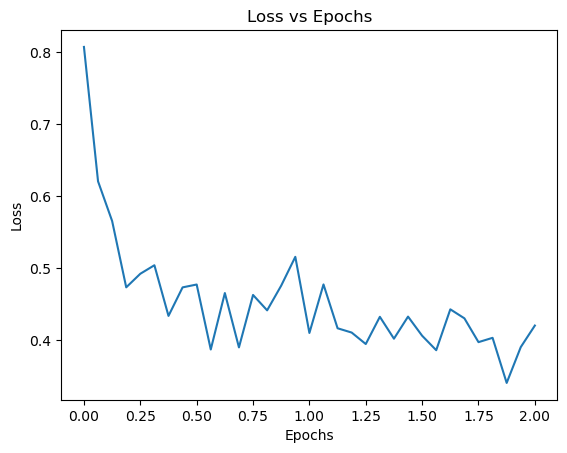

In [31]:
plt.plot(np.linspace(0,num_epochs,len(losses)),losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')

In [32]:
# torch.save(unet, '../models/U-Net_Image_Segmentation_IE643_New_Denser.pt')

In [33]:
# unet = torch.load('../models/U-Net_Image_Segmentation_IE643_New_Denser.pt')
unet.eval()

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (denseBlock1): DenseBlock(
    (conv1): Conv2d(64, 8, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(72, 8, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (norm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(80, 8, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (norm3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(88, 8, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (norm4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(96, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (norm5): BatchNorm2d(8, eps=1e-05, momentum=0.1,

# IoU Function

In [34]:
def binaryJaccardIndex(preds, masks):
    intersection = 0
    union = 0
    for pred, mask in zip(preds, masks):
        for pred_row, mask_row in zip(pred[0],mask[0]):
            for i,j in zip(pred_row, mask_row):
                if i==1 or j==1:
                    union+=1
                if i==1 and j==1:
                    intersection+=1
    return(intersection/union)

## Testing

In [35]:
threshold = 0.5

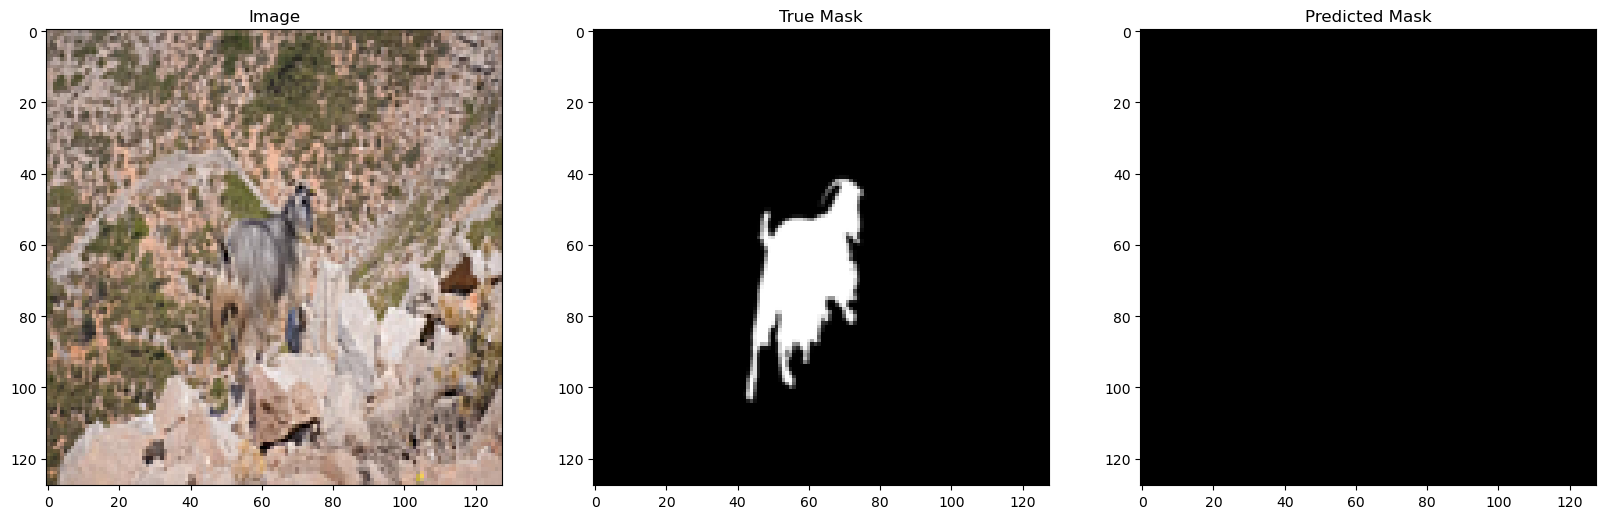

In [36]:
image, mask = next(iter(train_loader))
image = image.to(device)
mask = mask.to('cpu')
pred = unet(image).cpu()
pred1 = torch.relu(torch.sign(pred - threshold))
image = image.to('cpu')
image_show(image[0], mask[0], pred1[0])

In [33]:
IoU_value = binaryJaccardIndex(pred1, torch.round(mask).type(torch.int16))
IoU_value

0.36460486563841626

In [26]:
IoU_value = 0
for image, mask in train_loader:
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    pred = torch.relu(torch.sign(pred - threshold)) # Taking 0.4 as the threshold to make the value 1
    IoU_value += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16))
print(f'Intersection Over Union value = {IoU_value/len(train_loader)}')

KeyboardInterrupt: 

In [35]:
iou = IoU_value/len(train_loader)
dice_score = 2*iou/(1+iou)
print('Dice Score for Training data =',dice_score)

Dice Score for Training data = 0.5343742717315311


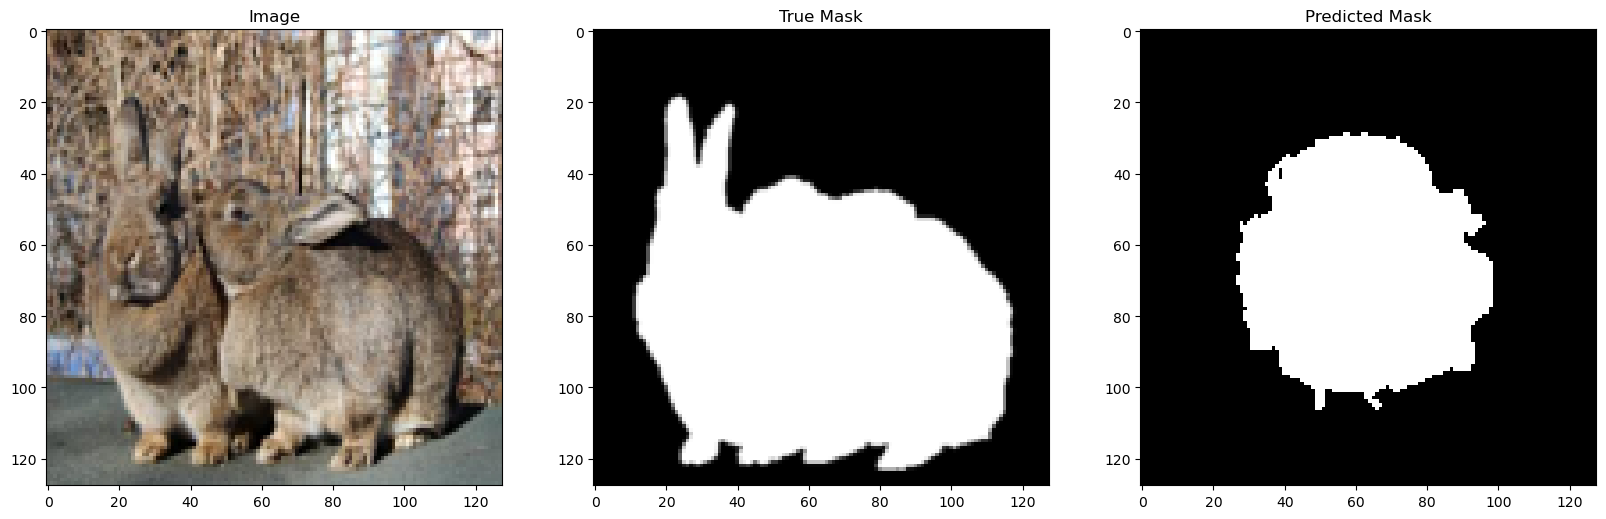

In [36]:
image, mask = next(iter(val_loader))
image = image.to(device)
mask = mask.to('cpu')
pred = unet(image).cpu()
pred1 = torch.relu(torch.sign(pred - threshold))
image = image.to('cpu')
image_show(image[0], mask[0], pred1[0])

In [37]:
IoU_value = binaryJaccardIndex(pred1, torch.round(mask).type(torch.int16))
IoU_value

0.26216591243471654

In [31]:
IoU_value = 0
for image, mask in val_loader:
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    pred = pred = torch.relu(torch.sign(pred - threshold))
    IoU_value += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16))
print(f'Intersection Over Union value = {IoU_value/len(val_loader)}')

Intersection Over Union value = 0.01085185993794956


In [32]:
iou = IoU_value/len(val_loader)
dice_score = 2*iou/(1+iou)
print('Dice Score for Validation data =',dice_score)

Dice Score for Validation data = 0.021470722601461493


## Continuing to Train for 10 more epochs

In [22]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=4e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.6)

In [26]:
num_epochs = 10
losses=[]
batches = len(train_loader)
print(batches)

16


In [24]:
unet.train()

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (denseBlock1): DenseBlock(
    (convFinal): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (normFinal): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (denseBlock2): DenseBlock(
    (convFinal): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (normFinal): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm3

In [27]:
tic = time.time()
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}; LR = {scheduler.get_last_lr()[0]}')
    for i, (images,masks) in enumerate(train_loader):
        images = images.to(device)
        masks = torch.round(masks).to(device)

        preds = unet(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Step {i+1}/{batches}; Loss = {loss.item():.4f}')
        losses.append(loss.item())
    scheduler.step()
print('Finished Training!')
print(f'Time Taken = {(time.time() - tic)//60:.0f}m {(time.time() - tic)%60:.0f}s')

Epoch 1/10; LR = 0.04
Step 1/16; Loss = 0.3605
Step 2/16; Loss = 0.3644
Step 3/16; Loss = 0.3761
Step 4/16; Loss = 0.3260
Step 5/16; Loss = 0.3675
Step 6/16; Loss = 0.3408
Step 7/16; Loss = 0.3029
Step 8/16; Loss = 0.3432
Step 9/16; Loss = 0.3670
Step 10/16; Loss = 0.3504
Step 11/16; Loss = 0.3321
Step 12/16; Loss = 0.3190
Step 13/16; Loss = 0.3544
Step 14/16; Loss = 0.3344
Step 15/16; Loss = 0.3192
Step 16/16; Loss = 0.3372
Epoch 2/10; LR = 0.024
Step 1/16; Loss = 0.3194
Step 2/16; Loss = 0.3475
Step 3/16; Loss = 0.3653
Step 4/16; Loss = 0.3461
Step 5/16; Loss = 0.3580
Step 6/16; Loss = 0.3248
Step 7/16; Loss = 0.3016
Step 8/16; Loss = 0.3123
Step 9/16; Loss = 0.3019
Step 10/16; Loss = 0.3751
Step 11/16; Loss = 0.3602
Step 12/16; Loss = 0.3138
Step 13/16; Loss = 0.3183
Step 14/16; Loss = 0.3306
Step 15/16; Loss = 0.3762
Step 16/16; Loss = 0.3072
Epoch 3/10; LR = 0.0144
Step 1/16; Loss = 0.3615
Step 2/16; Loss = 0.3219
Step 3/16; Loss = 0.3528
Step 4/16; Loss = 0.3097
Step 5/16; Loss =

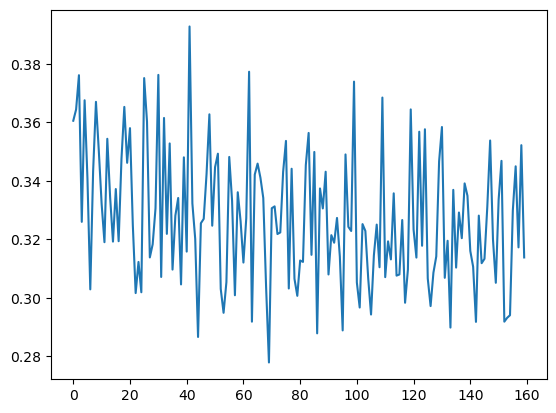

In [28]:
plt.plot(losses)

In [29]:
# unet = torch.load('../models/U-Net_Image_Segmentation_IE643_Dense.pt')
unet.eval()

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (denseBlock1): DenseBlock(
    (convFinal): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (normFinal): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (denseBlock2): DenseBlock(
    (convFinal): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (normFinal): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm3

In [30]:
threshold = 0.4

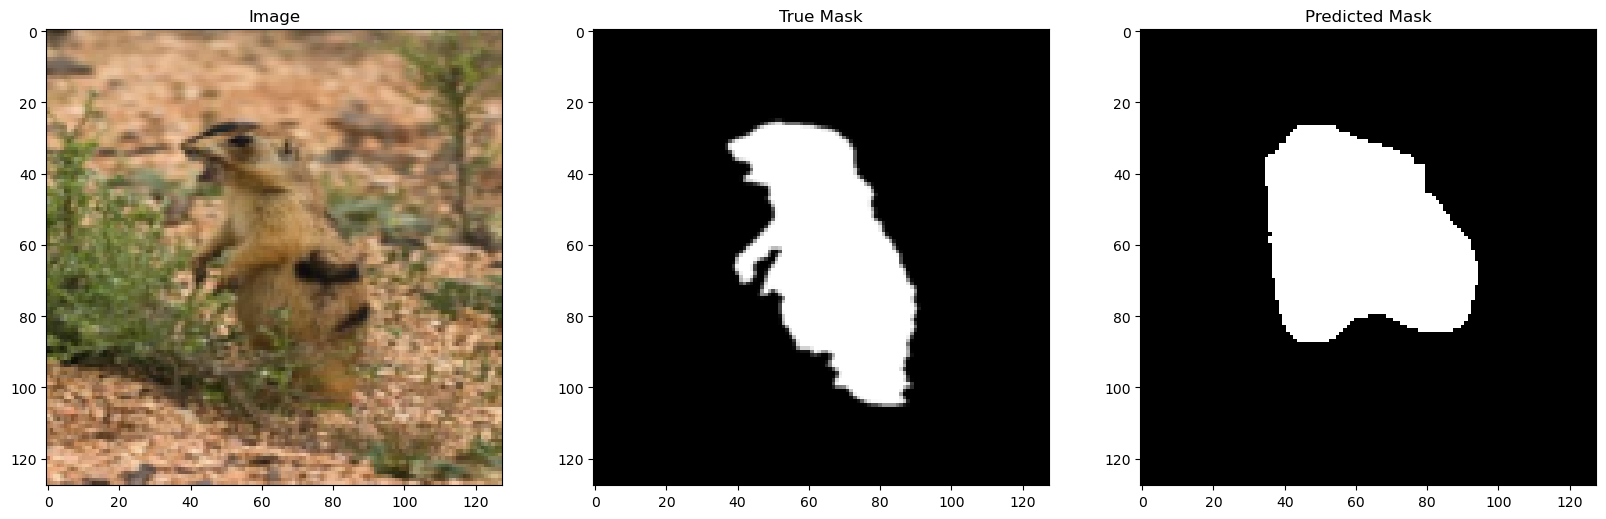

In [31]:
image, mask = next(iter(train_loader))
image = image.to(device)
mask = mask.to('cpu')
pred = unet(image).cpu()
pred1 = torch.relu(torch.sign(pred - threshold))
image = image.to('cpu')
image_show(image[0], mask[0], pred1[0])

In [32]:
IoU_value = 0
for image, mask in train_loader:
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    pred = torch.relu(torch.sign(pred - threshold)) # Taking 0.4 as the threshold to make the value 1
    IoU_value += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16))
print(f'Intersection Over Union value = {IoU_value/len(train_loader)}')

Intersection Over Union value = 0.6010907478630543


In [ ]:
IoU_value = IoU_value/len(val_loader)
dice_score = 2*IoU_value/(1+IoU_value)
print('Dice Score for Training =',dice_score)

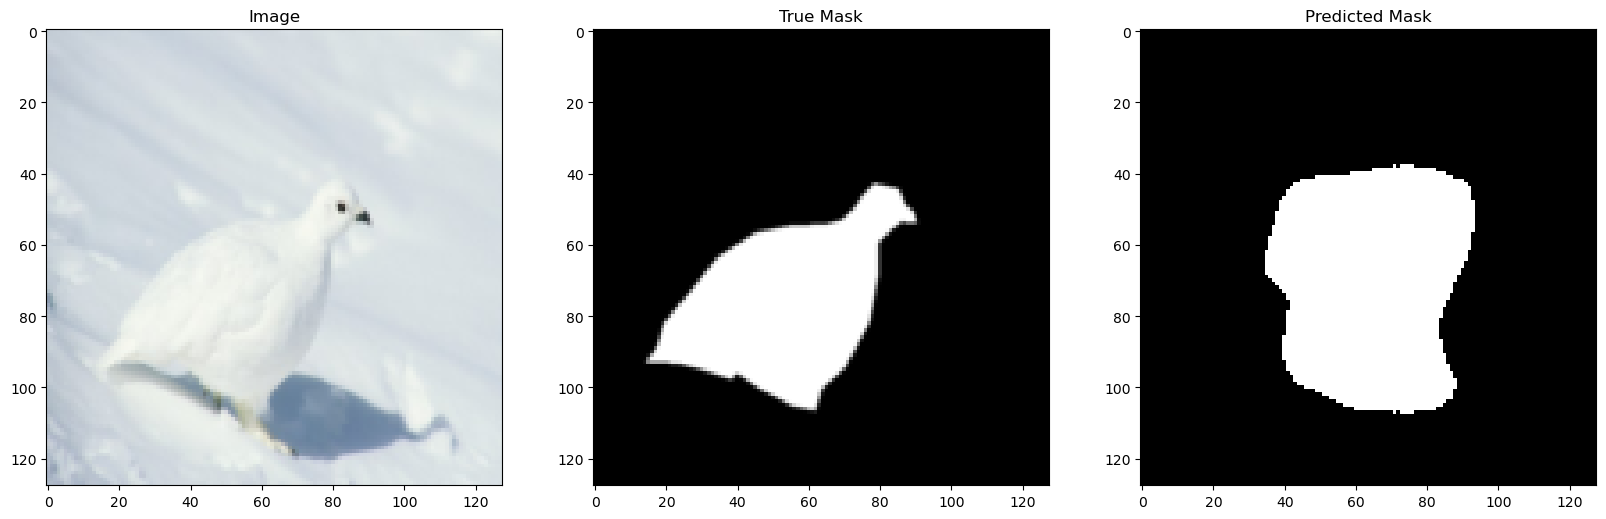

In [26]:
image, mask = next(iter(val_loader))
image = image.to(device)
mask = mask.to('cpu')
pred = unet(image).cpu()
pred1 = torch.relu(torch.sign(pred - threshold))
image = image.to('cpu')
image_show(image[0], mask[0], pred1[0])

In [35]:
IoU_value = 0
for image, mask in val_loader:
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    pred = torch.relu(torch.sign(pred - 0.4))
    IoU_value += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16))
print(f'Intersection Over Union value = {IoU_value/len(val_loader)}')

Intersection Over Union value = 0.5906559079885483


In [43]:
IoU_value = IoU_value/len(val_loader)
dice_score = 2*IoU_value/(1+IoU_value)
print('Dice Score for Validation =',dice_score)

Dice Score = 0.7426570448356209


In [35]:
# torch.save(unet, '../models/U-Net_Image_Segmentation_IE643_Dense_20_epochs.pt')

In [12]:
unet = torch.load('../models/U-Net_Image_Segmentation_IE643_Dense_20_epochs.pt')
unet.eval()

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (denseBlock1): DenseBlock(
    (convFinal): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (normFinal): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (denseBlock2): DenseBlock(
    (convFinal): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (normFinal): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm3

In [31]:
def binaryJaccardIndex(preds, masks):
    intersection = 0
    union = 0
    for pred, mask in zip(preds, masks):
        for pred_row, mask_row in zip(pred[0],mask[0]):
            for i,j in zip(pred_row, mask_row):
                if i==1 or j==1:
                    union+=1
                if i==1 and j==1:
                    intersection+=1
    return(intersection/union)

In [15]:
threshold = 0.4

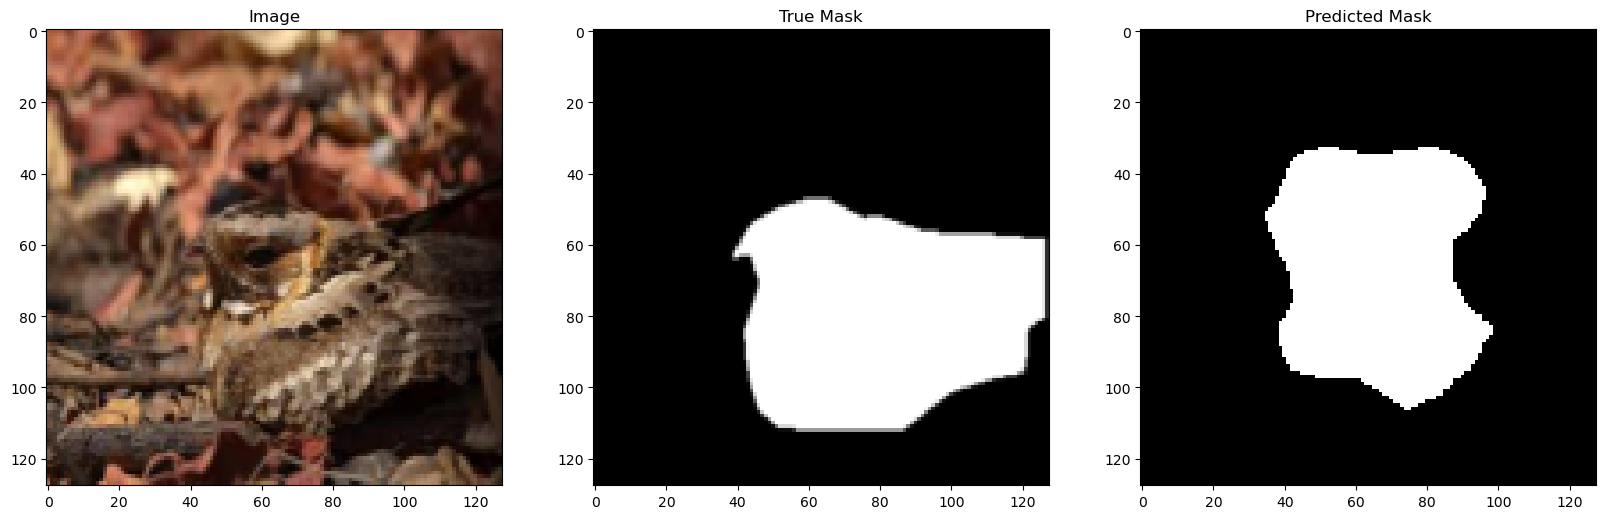

In [16]:
image, mask = next(iter(val_loader))
image = image.to(device)
mask = mask.to('cpu')
pred = unet(image).cpu()
pred1 = torch.relu(torch.sign(pred - threshold))
image = image.to('cpu')
image_show(image[0], mask[0], pred1[0])

In [29]:
binaryJaccardIndex(pred1, torch.round(mask).type(torch.int16))

0.33456579969520867

In [32]:
IoU_value = 0
for image, mask in val_loader:
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    pred = torch.relu(torch.sign(pred - 0.4))
    IoU_value += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16))
print(f'Intersection Over Union value = {IoU_value/len(val_loader)}')

Intersection Over Union value = 0.3247543194224404


In [34]:
dice_score = 2*0.3247543194224404/(1+0.3247543194224404)
dice_score

0.4902861076369618